```
python visualization.py --dataset_root ./data/ --object_model_root ./data/object_models_released --triplet "(stir, spoon, bowl)" --sequence_name "20231105_019" --save_path "./example.gif" --device "cuda:0"
python dataset_utils/visualization.py --dataset_root ./data/ --object_model_root ./data/object_models_released --triplet "(stir, spoon, bowl)" --sequence_name "20231105_019" --save_path "./example.gif" --device "cuda:0"
```

- https://github.com/leolyliu/TACO-Instructions


/home/satoshi/projects/taco/data

```
ls *.zip | parallel unzip -d /home/satoshi/projects/taco/data {}
```

python dataset_utils/visualization.py --dataset_root ./data/ --object_model_root ./data/object_models_released --triplet "(stir, spoon, bowl)" --sequence_name "20231105_019" --save_path "./example.gif" --device "cuda:0"

python dataset_utils/project_pose_to_egocentric_view.py --dataset_root ./data/ --object_model_root ./data/object_models_released  --triplet "(brush, brush, box)" --sequence_name "20231006_163" --save_path "./egocentric_example.gif" --device "cuda:0"

- https://chatgpt.com/c/68b5401f-89f4-8329-866f-c4a97a61b6c9

to uniquely identify a sequence, you need:
- triplet (action, tool, target)
    - '(stir, spoon, bowl)'
- sequence_name (unique ID within triplet)
    - '20231105_019'

## Camera Coordinates

* **World** = the dataset’s master coordinate system.
    * All poses (`tool_*.npy`, `target_*.npy`, `*_hand.pkl`) are expressed in **world coordinates**.
* **Fixed camera** = one stationary camera in the scene (same extrinsic for all frames).
* **Egocentric camera** = wearable camera (different extrinsic each frame).

Yes ✅ — the dataset has **both a fixed external camera** (lab-style view) **and an egocentric head-mounted camera** (what the subject sees).

## Hand
* **`*_hand_shape.pkl`** gives you the *static shape* of the subject’s hand (personalized β).
* **`*_hand.pkl`** gives you the *dynamic movement* per frame (θ).
* To reconstruct meshes:

  * Pass **β (shape)** + **θ (pose)** into MANO → get per-frame **hand vertices** (778 points) + faces.

## Object (Tool and Target)
* An **Object pose = (N\_frame, 4,4) matrices**
* Defines **where and how the tool/target is in the world** at each frame
* Needed to move the static object model into the right position/orientation per frame

#### 📦 What Is an Object Pose?

* Stored in:

  ```
  dataset_root/Object_Poses/(action, tool, target)/(sequence_name)/
      tool_<TOOL>.npy
      target_<TARGET>.npy
  ```

* Each file (`.npy`) contains:

  * Shape: `(N_frame, 4, 4)`
  * Each entry = **homogeneous transformation matrix** (SE(3)):

    ```
    [ R(3x3) | t(3x1) ]
    [ 0 0 0  |   1    ]
    ```

    * `R` = rotation matrix (orientation of the object in world coordinates)
    * `t` = translation vector (position of the object in world coordinates)

So at **frame i**:

```python
tool_pose = tool_poses[i]      # (4,4)
target_pose = target_poses[i]  # (4,4)
```

#### 🔧 How It’s Used

In your scripts, these matrices transform the **static 3D mesh model** into its posed version:

```python
# Get vertices in object space
tool_pts = tool_model.vertices  # shape (V, 3)

# Apply pose
tool_pose = tool_poses[frame_idx]
tool_vertices = (tool_pts @ tool_pose[:3, :3].T) + tool_pose[:3, 3]
```

* First multiply by rotation (`Rᵀ`)
* Then add translation (`t`)

Result = **tool mesh vertices in world coordinates** at this frame.


# I want to get hand skeleton

Nice — you want the **hand skeleton (joints)** for a given frame, not just the mesh.
Since TACO hands are represented using **MANO**, here’s how it works:

## 🖐️ MANO Outputs

When you pass **shape (β)** and **pose (θ)** into MANO, you can get:

1. **Mesh vertices** → `(778, 3)` points

   * Full hand surface

2. **Joints** → `(21, 3)` or `(16, 3)` points

   * Predefined skeleton keypoints
   * Computed as a **linear regressor of mesh vertices**
   * These are the **hand skeleton** you want


## 📦 In TACO Scripts

Right now, the provided code (`mano_params_to_hand_info`) is being used like:

```python
right_hand_vertices, _, right_hand_faces = mano_params_to_hand_info(
    join(hand_pose_dir, "right_hand.pkl"),
    mano_beta=right_hand_beta,
    side="right",
    max_cnt=None,
    return_pose=False,
    return_faces=True,
    device=device
)
```

This returns **vertices and faces**.
But MANO (via `mano_params_to_hand_info`) can also return **joints**, if you set the right flags.


## 🛠️ How to Get Skeleton for Frame *i*

Example:

```python
from hand_pose_loader import mano_params_to_hand_info

# Load shape parameters
right_hand_beta = pickle.load(open(join(hand_pose_dir, "right_hand_shape.pkl"), "rb"))["hand_shape"].reshape(10).detach().cpu().numpy()

# Get vertices + joints for all frames
right_hand_vertices, right_hand_joints, right_hand_faces = mano_params_to_hand_info(
    join(hand_pose_dir, "right_hand.pkl"),
    mano_beta=right_hand_beta,
    side="right",
    max_cnt=None,
    return_pose=True,      # request poses
    return_faces=True,
    device="cuda:0"
)

# Pick a frame
frame_id = 100
skeleton = right_hand_joints[frame_id]   # shape (21, 3)
print("Frame 100 skeleton joints:", skeleton)
```

* `skeleton[j]` = `(x, y, z)` of joint `j` in **world coordinates**
* Joints include: wrist, MCP, PIP, DIP, and fingertip for all 5 fingers

## 🌍 Coordinates of the Skeleton

* Returned joints are already in the **world coordinate system** (same as object poses).
* To visualize in a camera:

  * Apply extrinsic:

    ```
    X_camera = Extrinsic @ [X_world; 1]
    ```
  * Then project with intrinsic.

## 📑 Summary

* Each frame’s hand skeleton = **21 joints (3D)** from MANO
* Computed as a regressed subset of mesh vertices
* Use `mano_params_to_hand_info(..., return_pose=True)` to get them
* Output is in **world coordinates**



# IMPORTANT! the script root has to be chnaged to `./dataset_utils` for this notebook below

In [3]:
cd dataset_utils

/home/localstorage/ssd/satoshi/projects/taco/dataset_utils


/home/localstorage/ssd/miniconda3/envs/taco/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
triplet = "(stir, spoon, bowl)" 
sequence_name = "20231105_019"

In [ ]:
import os
import pickle
import numpy as np
import trimesh
from os.path import join, isfile, isdir

from video_utils import mp42imgs
from hand_pose_loader import mano_params_to_hand_info


# ==============================
# CONFIG
# ==============================
dataset_root = "/home/satoshi/projects/taco/data"
object_model_root = "/home/satoshi/projects/taco/data/object_models_released"

triplet = "(stir, spoon, bowl)"
sequence_name = "20231105_019"
device = "cuda:0"


# ==============================
# HELPERS
# ==============================
def discover_object_names(object_pose_dir):
    """Return (tool_name, target_name) from files like 'tool_spoon.npy'."""
    tool_name, target_name = None, None
    for fn in os.listdir(object_pose_dir):
        if fn.startswith("tool_") and fn.endswith(".npy"):
            tool_name = fn.split(".")[0].split("_", 1)[-1]
        elif fn.startswith("target_") and fn.endswith(".npy"):
            target_name = fn.split(".")[0].split("_", 1)[-1]
    if tool_name is None or target_name is None:
        raise FileNotFoundError(
            f"Could not find tool_/target_ pose .npy files in: {object_pose_dir}"
        )
    return tool_name, target_name


def load_intrinsic(path_txt_or_npy):
    """Load intrinsics from .txt or .npy"""
    if isfile(path_txt_or_npy):
        if path_txt_or_npy.endswith(".txt"):
            return np.loadtxt(path_txt_or_npy)
        elif path_txt_or_npy.endswith(".npy"):
            return np.load(path_txt_or_npy)
    raise FileNotFoundError(f"Camera intrinsic not found: {path_txt_or_npy}")


def try_load_third_person(third_cam_dir):
    """Try to load third-person camera intrinsics/extrinsics if present."""
    if not isdir(third_cam_dir):
        return None, None

    cand_intr = [
        join(third_cam_dir, "intrinsic.txt"),
        join(third_cam_dir, "intrinsic.npy"),
        join(third_cam_dir, "third_person_intrinsic.txt"),
        join(third_cam_dir, "third_person_intrinsic.npy"),
    ]
    cand_extr = [
        join(third_cam_dir, "extrinsic.txt"),
        join(third_cam_dir, "extrinsic.npy"),
        join(third_cam_dir, "third_person_extrinsic.txt"),
        join(third_cam_dir, "third_person_extrinsic.npy"),
    ]

    intr = None
    for p in cand_intr:
        if isfile(p):
            intr = np.loadtxt(p) if p.endswith(".txt") else np.load(p)
            break

    extr = None
    for p in cand_extr:
        if isfile(p):
            extr = np.loadtxt(p) if p.endswith(".txt") else np.load(p)
            if extr.shape == (4, 4):
                pass
            elif extr.ndim == 3 and extr.shape[-2:] == (4, 4):
                if extr.shape[0] == 1:  # squeeze if singleton
                    extr = extr[0]
            else:
                raise ValueError(f"Unexpected third-person extrinsic shape: {extr.shape}")
            break

    return intr, extr


def load_hand_joints(pkl_path, shape_pkl_path, side, device="cuda:0"):
    """Returns (N,21,3) world joints"""
    beta = pickle.load(open(shape_pkl_path, "rb"))["hand_shape"].reshape(10).detach().cpu().numpy()
    # NOTE: return_faces must be False (your version asserts against it)
    hand_vertices, hand_joints, *_ = mano_params_to_hand_info(
        pkl_path,
        mano_beta=beta,
        side=side,
        max_cnt=None,
        return_pose=True,
        return_faces=False,
        device=device,
    )
    return hand_joints


# ==============================
# LOAD DATA
# ==============================
object_pose_dir = join(dataset_root, "Object_Poses", triplet, sequence_name)
hand_pose_dir   = join(dataset_root, "Hand_Poses", triplet, sequence_name)
ego_cam_dir     = join(dataset_root, "Egocentric_Camera_Parameters", triplet, sequence_name)
ego_rgb_path    = join(dataset_root, "Egocentric_RGB_Videos", triplet, sequence_name, "color.mp4")
third_cam_dir   = join(dataset_root, "Third_Person_Camera_Parameters", triplet, sequence_name)

# Tool/target names
tool_name, target_name = discover_object_names(object_pose_dir)
print(f"tool={tool_name} | target={target_name}")

# Egocentric frames
frames_ego = 
(ego_rgb_path, return_rgb=True, max_cnt=None)
print(f"Egocentric frames: {len(frames_ego)}")

# Hand joints
handpose_left  = load_hand_joints(join(hand_pose_dir, "left_hand.pkl"),
                                  join(hand_pose_dir, "left_hand_shape.pkl"),
                                  side="left", device=device)
handpose_right = load_hand_joints(join(hand_pose_dir, "right_hand.pkl"),
                                  join(hand_pose_dir, "right_hand_shape.pkl"),
                                  side="right", device=device)
print("Hand joints:", handpose_left.shape, handpose_right.shape)

# Object poses + meshes
tool_obj_pose   = np.load(join(object_pose_dir, f"tool_{tool_name}.npy"))
target_obj_pose = np.load(join(object_pose_dir, f"target_{target_name}.npy"))

tool_obj_mesh   = trimesh.load(join(object_model_root, f"{tool_name}_cm.obj"))
target_obj_mesh = trimesh.load(join(object_model_root, f"{target_name}_cm.obj"))
tool_obj_mesh.vertices   *= 0.01
target_obj_mesh.vertices *= 0.01
print("Tool/target poses:", tool_obj_pose.shape, target_obj_pose.shape)

# Egocentric camera
ego_intrinsic = load_intrinsic(join(ego_cam_dir, "egocentric_intrinsic.txt"))
ego_extrinsic = np.load(join(ego_cam_dir, "egocentric_frame_extrinsic.npy"))
print("Ego intrinsics:", ego_intrinsic.shape, "Ego extrinsics:", ego_extrinsic.shape)

# Third-person (optional)
exo_intrinsic, exo_extrinsic = try_load_third_person(third_cam_dir)


# ==============================
# SYNCHRONIZE
# ==============================
n_sync = min(
    len(frames_ego),
    handpose_left.shape[0],
    handpose_right.shape[0],
    tool_obj_pose.shape[0],
    target_obj_pose.shape[0],
    ego_extrinsic.shape[0]
)

frames_ego     = frames_ego[:n_sync]
handpose_left  = handpose_left[:n_sync]
handpose_right = handpose_right[:n_sync]
tool_obj_pose  = tool_obj_pose[:n_sync]
target_obj_pose= target_obj_pose[:n_sync]
ego_extrinsic  = ego_extrinsic[:n_sync]

print("-------------------------------")
print("frames_ego:", len(frames_ego))
print("handpose_left:", handpose_left.shape[0])
print("handpose_right:", handpose_right.shape[0])
print("tool_obj_pose:", tool_obj_pose.shape[0])
print("target_obj_pose:", target_obj_pose.shape[0])
print("ego_extrinsic:", ego_extrinsic.shape[0])
print(f"Synchronized sequence length: {n_sync} frames")
print("-------------------------------")


# ==============================
# EXAMPLE FRAME
# ==============================
idx = 100 if n_sync > 100 else 0

frame_rgb   = frames_ego[idx]          
hand_l      = handpose_left[idx]       
hand_r      = handpose_right[idx]      
tool_pose   = tool_obj_pose[idx]       
target_pose = target_obj_pose[idx]     
ego_ext_i   = ego_extrinsic[idx]       

print("Egocentric RGB frame:", frame_rgb.shape, frame_rgb.dtype)
print("Left hand joints:", hand_l.shape)
print("Right hand joints:", hand_r.shape)
print("Tool pose:", tool_pose.shape)
print("Target pose:", target_pose.shape)
print("Ego intrinsics:", ego_intrinsic.shape)
if exo_intrinsic is not None:
    print("Exo intrinsics:", exo_intrinsic.shape)
if exo_extrinsic is not None:
    print("Exo extrinsic:", exo_extrinsic.shape)


tool=032 | target=024
Egocentric frames: 249
Hand joints: (249, 21, 3) (249, 21, 3)
Tool/target poses: (249, 4, 4) (249, 4, 4)
Ego intrinsics: (3, 3) Ego extrinsics: (249, 4, 4)
-------------------------------
frames_ego: 249
handpose_left: 249
handpose_right: 249
tool_obj_pose: 249
target_obj_pose: 249
ego_extrinsic: 249
Synchronized sequence length: 249 frames
-------------------------------
Egocentric RGB frame: (1080, 1920, 3) uint8
Left hand joints: (21, 3)
Right hand joints: (21, 3)
Tool pose: (4, 4)
Target pose: (4, 4)
Ego intrinsics: (3, 3)


### Plot image

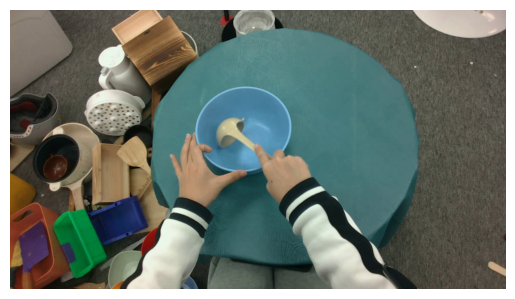

In [8]:
import matplotlib.pyplot as plt
plt.imshow(frame_rgb)
plt.axis("off")
plt.show()

### Plot hands

In [9]:
from utils_vis import plotly_joints, plotly_cube, plotly_cam, plotly_points, plotly_line, axes2video 
from utils_vis import (
    visualize_joints_2d,
    visualize_joints_3d,
    visualize_cube_2d,
    visualize_cube_3d,
    visualize_cam_3d,
)
import plotly.graph_objs as go


In [10]:
#3D plot
scale = 1
traces = []
traces += plotly_joints(hand_l*scale)
traces += plotly_joints(hand_r*scale)
# traces += plotly_cube(cube_corners_worldcoord*scale, cube_edges)

fig = go.Figure(data=traces)
fig.update_layout(
    scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"),
    margin=dict(l=0, r=0, b=0, t=0),
)
fig.show()

## + plot mesh

In [11]:
tool_obj_mesh

<trimesh.Trimesh(vertices.shape=(30087, 3), faces.shape=(60174, 3))>

In [12]:
import plotly.graph_objects as go

def plotly_mesh(mesh, color='lightblue', opacity=0.5, name='Mesh'):
    """
    Converts a trimesh.Trimesh object to a Plotly Mesh3d trace.
    """
    vertices = mesh.vertices
    faces = mesh.faces

    x = vertices[:, 0]
    y = vertices[:, 1]
    z = vertices[:, 2]

    i = faces[:, 0]
    j = faces[:, 1]
    k = faces[:, 2]

    return go.Mesh3d(
        x=x,
        y=y,
        z=z,
        i=i,
        j=j,
        k=k,
        color=color,
        opacity=opacity,
        name=name
    )


In [13]:
import plotly.graph_objects as go

def plotly_mesh(mesh, color='lightblue', opacity=0.5, name='Mesh'):
    """
    Converts a trimesh.Trimesh object to a Plotly Mesh3d trace.
    """
    vertices = mesh.vertices
    faces = mesh.faces

    x = vertices[:, 0]
    y = vertices[:, 1]
    z = vertices[:, 2]

    i = faces[:, 0]
    j = faces[:, 1]
    k = faces[:, 2]

    return go.Mesh3d(
        x=x,
        y=y,
        z=z,
        i=i,
        j=j,
        k=k,
        color=color,
        opacity=opacity,
        name=name
    )

# ---------------------
# Main 3D plot section
# ---------------------

# Scale if needed (e.g., mm to meters)
scale = 1

# Frame index (0 to 248)
frame_idx = 0

# Get current frame data
hand_l_frame = hand_l * scale       # (21, 3)
hand_r_frame = hand_r * scale       # (21, 3)
tool_pose_frame = tool_pose         # (4, 4)
target_pose_frame = target_pose     # (4, 4)

# Init Plotly traces
traces = []

# Plot hand joints
traces += plotly_joints(hand_l_frame)
traces += plotly_joints(hand_r_frame)

# Transform tool mesh
tool_mesh_world = tool_obj_mesh.copy()
tool_mesh_world.apply_transform(tool_pose_frame)
traces.append(plotly_mesh(tool_mesh_world, color='orange', opacity=0.7, name='Tool'))

# Transform target mesh
target_mesh_world = target_obj_mesh.copy()
target_mesh_world.apply_transform(target_pose_frame)
traces.append(plotly_mesh(target_mesh_world, color='green', opacity=0.5, name='Target'))

# Create the figure
fig = go.Figure(data=traces)
fig.update_layout(
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z",
        aspectmode='data',
    ),
    margin=dict(l=0, r=0, b=0, t=0),
)
fig.show()


### plot bounding box

In [17]:
import numpy as np
import plotly.graph_objects as go
import trimesh


# ===============================
# Helpers
# ===============================

def compute_aabb_corners(vertices):
    """
    Compute 8 corners of the axis-aligned bounding box (AABB) of a mesh.
    Returns (8, 3) numpy array.
    """
    min_pt = np.min(vertices, axis=0)
    max_pt = np.max(vertices, axis=0)

    # 8 corners of the AABB
    corners = np.array([
        [min_pt[0], min_pt[1], min_pt[2]],
        [max_pt[0], min_pt[1], min_pt[2]],
        [max_pt[0], max_pt[1], min_pt[2]],
        [min_pt[0], max_pt[1], min_pt[2]],
        [min_pt[0], min_pt[1], max_pt[2]],
        [max_pt[0], min_pt[1], max_pt[2]],
        [max_pt[0], max_pt[1], max_pt[2]],
        [min_pt[0], max_pt[1], max_pt[2]],
    ])
    return corners


def transform_points(points, transform):
    """
    Applies a 4x4 transformation matrix to Nx3 points.
    """
    points_hom = np.hstack([points, np.ones((points.shape[0], 1))])  # (N, 4)
    transformed = (transform @ points_hom.T).T[:, :3]
    return transformed  # (N, 3)

cube_edges = [
    (0,1), (1,2), (2,3), (3,0),  # bottom
    (4,5), (5,6), (6,7), (7,4),  # top
    (0,4), (1,5), (2,6), (3,7),  # verticals
]


# ===============================
# Visualization Entry Point
# ===============================

# Assume these variables already exist:
# hand_l, hand_r, tool_pose, target_pose, tool_obj_mesh, target_obj_mesh

scale = 1
traces = []

# Plot hand joints
traces += plotly_joints(hand_l * scale)
traces += plotly_joints(hand_r * scale)

# Compute AABB bounding boxes in canonical space
tool_canon_box = compute_aabb_corners(tool_obj_mesh.vertices)
target_canon_box = compute_aabb_corners(target_obj_mesh.vertices)

# Transform into world space
tool_box_world = transform_points(tool_canon_box, tool_pose)
target_box_world = transform_points(target_canon_box, target_pose)

# Plot bounding boxes
traces += plotly_cube(tool_box_world,cube_edges,color='orange',width=3)
traces += plotly_cube(target_box_world,cube_edges,color='green',width=3)

# Plot figure
fig = go.Figure(data=traces)
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data',
    ),
    margin=dict(l=0, r=0, b=0, t=0),
)
fig.show()

## plot camera

In [ ]:
import numpy as np
import plotly.graph_objects as go

def plotly_cam(world2cam, intrinsic, near_plane_z=0.05, far_plane_z=0.5, color='purple', name='Camera', arrow_scale=0.05):
    """
    Plot camera frustum and image-space axes (u, v) in world space.
    
    Parameters:
        world2cam: (4, 4) np.array — Extrinsic matrix (world → camera)
        intrinsic: (3, 3) np.array — Camera intrinsics
        near_plane_z: float — Near plane depth
        far_plane_z: float — Far plane depth
        color: str — Frustum line color
        name: str — Legend name
        arrow_scale: float — Length of u/v arrows
    Returns:
        List of Plotly Scatter3d traces
    """
    cam2world = np.linalg.inv(world2cam)

    fx = intrinsic[0, 0]
    fy = intrinsic[1, 1]
    cx = intrinsic[0, 2]
    cy = intrinsic[1, 2]

    img_w = cx * 2
    img_h = cy * 2

    def get_frustum_corners(z):
        x0 = (0 - cx) * z / fx
        x1 = (img_w - cx) * z / fx
        y0 = (0 - cy) * z / fy
        y1 = (img_h - cy) * z / fy
        return np.array([
            [x0, y0, z],
            [x1, y0, z],
            [x1, y1, z],
            [x0, y1, z]
        ])

    cam_origin = np.array([[0, 0, 0]])
    near_corners = get_frustum_corners(near_plane_z)
    far_corners = get_frustum_corners(far_plane_z)
    frustum_points_cam = np.vstack([cam_origin, near_corners, far_corners])
    frustum_points_world = transform_points(frustum_points_cam, cam2world)

    O = 0  # origin
    N0, N1, N2, N3 = 1, 2, 3, 4
    F0, F1, F2, F3 = 5, 6, 7, 8

    edges = [
        (O, N0), (O, N1), (O, N2), (O, N3),
        (N0, N1), (N1, N2), (N2, N3), (N3, N0),
        (F0, F1), (F1, F2), (F2, F3), (F3, F0),
        (N0, F0), (N1, F1), (N2, F2), (N3, F3),
    ]

    traces = []

    for start, end in edges:
        traces.append(go.Scatter3d(
            x=[frustum_points_world[start, 0], frustum_points_world[end, 0]],
            y=[frustum_points_world[start, 1], frustum_points_world[end, 1]],
            z=[frustum_points_world[start, 2], frustum_points_world[end, 2]],
            mode='lines',
            line=dict(color=color, width=2),
            name=name,
            showlegend=False
        ))

    # ---------------------------------------
    # Draw u/v arrows from camera center
    # ---------------------------------------
    # Camera-space unit vectors
    cam_uv_vectors = np.array([
        [1, 0, 0],  # u-axis (right in image)
        [0, 1, 0],  # v-axis (down in image)
    ]) * arrow_scale

    # Transform origin + arrow tips to world space
    origin_world = transform_points(np.array([[0, 0, 0]]), cam2world)[0]
    uv_tips_world = transform_points(cam_uv_vectors, cam2world)

    u_tip = uv_tips_world[0]
    v_tip = uv_tips_world[1]

    # Arrow for u (red)
    traces.append(go.Scatter3d(
        x=[origin_world[0], u_tip[0]],
        y=[origin_world[1], u_tip[1]],
        z=[origin_world[2], u_tip[2]],
        mode='lines+text',
        line=dict(color='red', width=5),
        name='u-axis',
        text=["", "u"],
        textposition="top center",
        showlegend=False
    ))

    # Arrow for v (green)
    traces.append(go.Scatter3d(
        x=[origin_world[0], v_tip[0]],
        y=[origin_world[1], v_tip[1]],
        z=[origin_world[2], v_tip[2]],
        mode='lines+text',
        line=dict(color='green', width=5),
        name='v-axis',
        text=["", "v"],
        textposition="top center",
        showlegend=False
    ))

    return traces


def transform_points(points, transform):
    points_hom = np.hstack([points, np.ones((points.shape[0], 1))])
    transformed = (transform @ points_hom.T).T[:, :3]
    return transformed


import numpy as np
import plotly.graph_objects as go
import trimesh


# ===============================
# Helpers
# ===============================

def compute_aabb_corners(mesh):
    """
    Compute 8 corners of the axis-aligned bounding box (AABB) of a mesh.
    Returns (8, 3) numpy array.
    """
    v = mesh.vertices
    min_pt = np.min(v, axis=0)
    max_pt = np.max(v, axis=0)

    # 8 corners of the AABB
    corners = np.array([
        [min_pt[0], min_pt[1], min_pt[2]],
        [max_pt[0], min_pt[1], min_pt[2]],
        [max_pt[0], max_pt[1], min_pt[2]],
        [min_pt[0], max_pt[1], min_pt[2]],
        [min_pt[0], min_pt[1], max_pt[2]],
        [max_pt[0], min_pt[1], max_pt[2]],
        [max_pt[0], max_pt[1], max_pt[2]],
        [min_pt[0], max_pt[1], max_pt[2]],
    ])
    return corners


def transform_points(points, transform):
    """
    Applies a 4x4 transformation matrix to Nx3 points.
    """
    points_hom = np.hstack([points, np.ones((points.shape[0], 1))])  # (N, 4)
    transformed = (transform @ points_hom.T).T[:, :3]
    return transformed  # (N, 3)

cube_edges = [
    (0,1), (1,2), (2,3), (3,0),  # bottom
    (4,5), (5,6), (6,7), (7,4),  # top
    (0,4), (1,5), (2,6), (3,7),  # verticals
]


# ===============================
# Visualization Entry Point
# ===============================

# Assume these variables already exist:
# hand_l, hand_r, tool_pose, target_pose, tool_obj_mesh, target_obj_mesh

scale = 1
traces = []

# Plot hand joints
traces += plotly_joints(hand_l * scale)
traces += plotly_joints(hand_r * scale)

# Compute AABB bounding boxes in canonical space
tool_canon_box = compute_aabb_corners(tool_obj_mesh)
target_canon_box = compute_aabb_corners(target_obj_mesh)

# Transform into world space
tool_box_world = transform_points(tool_canon_box, tool_pose)
target_box_world = transform_points(target_canon_box, target_pose)

# Plot bounding boxes
traces += plotly_cube(tool_box_world,cube_edges,color='orange',width=3)
traces += plotly_cube(target_box_world,cube_edges,color='green',width=3)

# camera
cam_intr = ego_intrinsic
world2cam = ego_ext_i
traces += plotly_cam(world2cam, cam_intr, near_plane_z=0.1, far_plane_z=1, color='purple')


# Plot figure
fig = go.Figure(data=traces)
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data',
    ),
    margin=dict(l=0, r=0, b=0, t=0),
)
fig.show()

### plot into 2d image

3D world coordinates:
Tool box : (8, 3)
Target box: (8, 3)
Left hand: (21, 3)
Right hand: (21, 3)
ego_intrinsics: (3, 3)
ego_ext_i: (4, 4)
----------------------------------
2D projections:
Tool box (2D): (8, 2)
Target box (2D): (8, 2)
Left hand (2D): (21, 2)
Right hand (2D): (21, 2)
----------------------------------


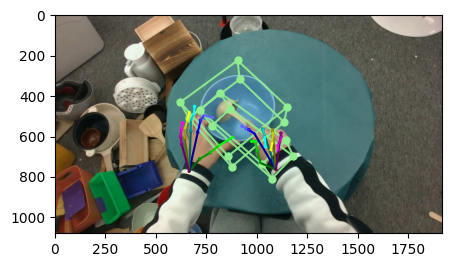

In [16]:
import numpy as np

def project_to_image(points_world, K, world2cam):
    """
    Project 3D world points into 2D image pixels.

    Args:
        points_world : (N,3) array in world coordinates
        K            : (3,3) intrinsic matrix
        world2cam    : (4,4) extrinsic (world → camera)
    Returns:
        (N,2) pixel coordinates (u,v)
    """
    N = points_world.shape[0]
    pts_h = np.hstack([points_world, np.ones((N,1))])  # (N,4)

    # world → camera
    pts_cam = (world2cam @ pts_h.T).T  # (N,4)

    Xc, Yc, Zc = pts_cam[:,0], pts_cam[:,1], pts_cam[:,2]
    Zc[Zc <= 1e-6] = 1e-6  # guard against div0

    # camera → pixels
    uvw = (K @ np.vstack([Xc, Yc, Zc])).T  # (N,3)
    u = uvw[:,0] / uvw[:,2]
    v = uvw[:,1] / uvw[:,2]

    #* (u,v) aligns with image array indexing (frame[v, u]).

    return np.stack([u, v], axis=1)

print("3D world coordinates:")
print("Tool box :", tool_box_world.shape)
print("Target box:", target_box_world.shape)
print("Left hand:", hand_l.shape)
print("Right hand:", hand_r.shape)
print("ego_intrinsics:", ego_intrinsic.shape)
print("ego_ext_i:", ego_ext_i.shape)
print("----------------------------------")

# Project each set into image coordinates
tool_box_2d   = project_to_image(tool_box_world, ego_intrinsic, ego_ext_i)
target_box_2d = project_to_image(target_box_world, ego_intrinsic, ego_ext_i)
hand_l_2d     = project_to_image(hand_l, ego_intrinsic, ego_ext_i)
hand_r_2d     = project_to_image(hand_r, ego_intrinsic, ego_ext_i)

print("2D projections:")
print("Tool box (2D):", tool_box_2d.shape)
print("Target box (2D):", target_box_2d.shape)
print("Left hand (2D):", hand_l_2d.shape)
print("Right hand (2D):", hand_r_2d.shape)
print("----------------------------------")


# matplotlib
# 2D plot
cube_edges = [
    (0,1), (1,2), (2,3), (3,0),  # bottom
    (4,5), (5,6), (6,7), (7,4),  # top
    (0,4), (1,5), (2,6), (3,7),  # verticals
]
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
img = frame_rgb
ax.imshow(img)
visualize_cube_2d(tool_box_2d, cube_edges, ax)
visualize_cube_2d(target_box_2d, cube_edges, ax)
ax = visualize_joints_2d(hand_l_2d, ax)
ax = visualize_joints_2d(hand_r_2d, ax)
plt.show()

# next steps
- cleanup the code
- make a dataloader
- check the cleaned code
- check in movie
- do integrity check for all of the datapoints (how?)
- make a preprocessed dataset